In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt

In [2]:
def plot_result(result,start_from=1,period=20,file_name="result",title="Event Study Coefficients with Confidence Intervals"):
    summary_table=pd.DataFrame(result.summary.tables[1].data[start_from:start_from+period],columns=result.summary.tables[1].data[0])
    new_row=[0]*len(summary_table.columns)
    insert_index = 4
    summary_table = pd.concat([summary_table.iloc[:insert_index], pd.DataFrame([new_row],columns=summary_table.columns), summary_table.iloc[insert_index:]]).reset_index(drop=True)

    summary_table["Time"]=np.array(list(range(-5,period-5+1)))
    # make each column of summary_table numeric
    summary_table=summary_table.apply(pd.to_numeric, errors='ignore')
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    # Plot coefficients as points
    plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

    # Plot confidence intervals as error bars
    # plt.errorbar(summary_table['Time'], summary_table["Parameter"],
    #              yerr=[summary_table["Parameter"] - summary_table['Lower CI'],
    #                    summary_table['Upper CI'] - summary_table["Parameter"]],
    #              fmt='none', ecolor='orange', elinewidth=2, capsize=4, label='Confidence Intervals')

    plt.fill_between(summary_table['Time'], summary_table['Lower CI'], summary_table['Upper CI'], color='orange', alpha=0.3, label='Confidence Intervals')

    plt.xlabel('Time')
    plt.ylabel("Parameter")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/{}.png".format(file_name),dpi=300,bbox_inches="tight",transparent=False,facecolor="white")
    plt.show()
    # return summary_table

In [3]:
df=pd.read_csv("../data/merged/len3_ship_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)

Estimation

In [4]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
5867    0
5868    0
5869    0
5870    0
5871    0
Name: mon_1, Length: 5872, dtype: uint8

In [5]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [6]:
# change to the datetime format
df['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=26))
df=df.set_index(["id","year_month"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2339 entries, (114, Timestamp('2009-11-26 00:00:00')) to (799, Timestamp('2022-12-26 00:00:00'))
Columns: 125 entries, year to year_trend
dtypes: float64(11), int32(3), int64(93), object(6), uint8(12)
memory usage: 2.0+ MB


(125, 167, 27)

In [7]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
elasped_m5 -4.278e+05  5.395e+05    -0.7930     0.4279  -1.486e+06   6.302e+05
elasped_m4 -1.069e+06  6.306e+05    -1.6952     0.0902  -2.306e+06   1.677e+05
elasped_m3 -1.163e+05  2.329e+06    -0.0499     0.9602  -4.683e+06   4.451e+06
elasped_m2 -6.913e+05  1.036e+06    -0.6671     0.5048  -2.724e+06   1.341e+06
elasped_0  -2.422e+06  4.983e+05    -4.8613     0.0000    -3.4e+06  -1.445e+06
elasped_1  -1.622e+06  5.863e+05    -2.7670     0.0057  -2.772e+06  -4.725e+05
elasped_2  -2.231e+05  6.887e+05    -0.3240     0.7460  -1.574e+06   1.127e+06
elasped_3   4.095e+05  5.716e+05     0.7165     0.4738  -7.114e+05   1.531e+06
elasped_4  -4.342e+05  4.132e+05    -1.0510     0.2934  -1.244e+06    3.76e+05
elasped_5   5.528e+04  4.503e+05     0.1228     0.90

C:\Users\hakos\AppData\Local\Temp\ipykernel_3884\3004208447.py:15: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


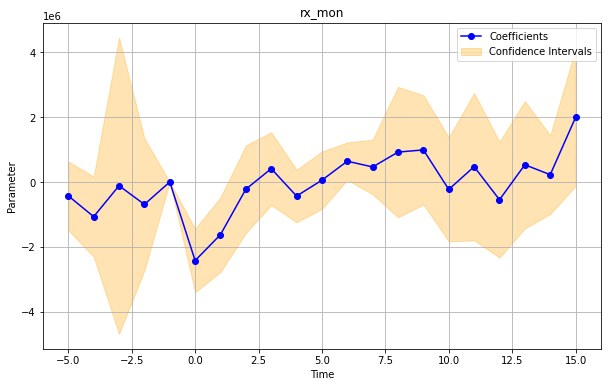

In [8]:
formula="rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"

# stock lag
# formula="rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+stock_rx_lag+TimeEffects+EntityEffects"

# with month dummies
# formula+=months

# ytrend
# formula+=ytrend

# mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
# drop_absorbed=True
mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_mon",title="rx_mon")

C:\Users\hakos\AppData\Local\Temp\ipykernel_3884\1248238978.py:13: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
elasped_m5    -0.0245     0.1488    -0.1646     0.8692     -0.3163      0.2673
elasped_m4    -0.2448     0.0979    -2.5000     0.0125     -0.4368     -0.0528
elasped_m3    -0.0359     0.0874    -0.4111     0.6811     -0.2073      0.1355
elasped_m2    -0.0757     0.0482    -1.5702     0.1165     -0.1702      0.0188
elasped_0     -0.1709     0.0417    -4.0976     0.0000     -0.2527     -0.0891
elasped_1     -0.1017     0.0501    -2.0271     0.0428     -0.2000     -0.0033
elasped_2     -0.0670     0.0595    -1.1260     0.2603     -0.1836      0.0497
elasped_3      0.0671     0.0554     1.2122     0.2256     -0.0415      0.1757
elasped_4      0.0665     0.0743     0.8955     0.3706     -0.0792      0.2123
elasped_5      0.0357     0.1137     0.3143     0.75

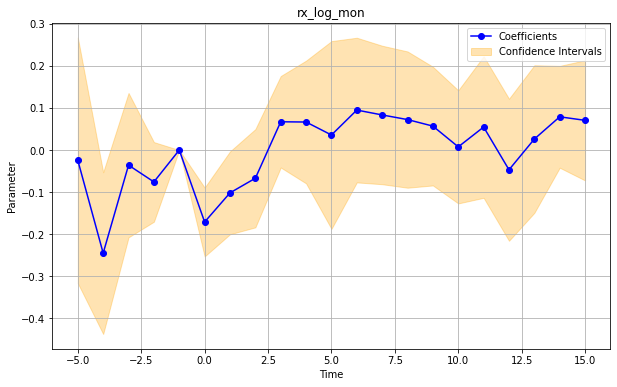

In [9]:
# take log
formula="log_rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version and month dummies
# formula="log_rx_dom ~ generic_per+log_stock_rx_lag+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"

# with months
# formula+=months

# ytrend
# formula+=ytrend

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon",title="rx_log_mon")

### OTC

C:\Users\hakos\AppData\Local\Temp\ipykernel_3884\3839554796.py:15: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
elasped_m5 -2.175e+05  2.335e+05    -0.9315     0.3517  -6.754e+05   2.404e+05
elasped_m4 -3.545e+05   2.01e+05    -1.7640     0.0779  -7.486e+05    3.96e+04
elasped_m3 -4.988e+05  2.001e+05    -2.4929     0.0127  -8.913e+05  -1.064e+05
elasped_m2 -2.655e+05  3.396e+05    -0.7819     0.4344  -9.315e+05   4.005e+05
elasped_0    2.76e+05  2.292e+05     1.2043     0.2286  -1.735e+05   7.255e+05
elasped_1   4.889e+05  2.928e+05     1.6697     0.0951  -8.531e+04   1.063e+06
elasped_2   1.634e+05   4.19e+05     0.3900     0.6965  -6.583e+05   9.851e+05
elasped_3  -2.198e+05   3.72e+05    -0.5909     0.5547  -9.493e+05   5.097e+05
elasped_4  -5.617e+05  3.671e+05    -1.5299     0.1262  -1.282e+06   1.583e+05
elasped_5  -8.388e+05  4.603e+05    -1.8224     0.06

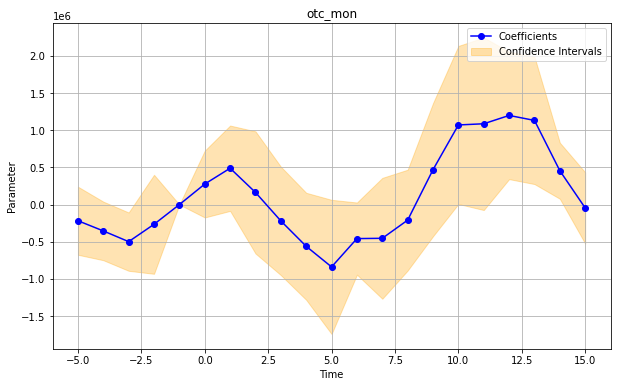

In [10]:

formula="otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"


# stock lag only
# formula+="+stock_otc_lag"

# # with months
# formula+=months

# # ytrend
# formula+=ytrend


mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="otc_mon",title="otc_mon")

C:\Users\hakos\AppData\Local\Temp\ipykernel_3884\777048945.py:25: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
elasped_m5    -1.1653     0.4808    -2.4233     0.0155     -2.1082     -0.2223
elasped_m4    -0.9394     0.3509    -2.6774     0.0075     -1.6276     -0.2513
elasped_m3    -0.5635     0.3636    -1.5498     0.1213     -1.2766      0.1495
elasped_m2    -0.1210     0.3204    -0.3776     0.7057     -0.7493      0.5073
elasped_0     -0.3605     0.3427    -1.0521     0.2929     -1.0325      0.3115
elasped_1     -0.3034     0.4535    -0.6689     0.5036     -1.1928      0.5860
elasped_2     -0.9457     0.5270    -1.7945     0.0729     -1.9791      0.0878
elasped_3     -0.5028     0.4871    -1.0322     0.3021     -1.4580      0.4525
elasped_4     -0.7105     0.4395    -1.6166     0.1061     -1.5724      0.1514
elasped_5     -0.8234     0.4477    -1.8391     0.06

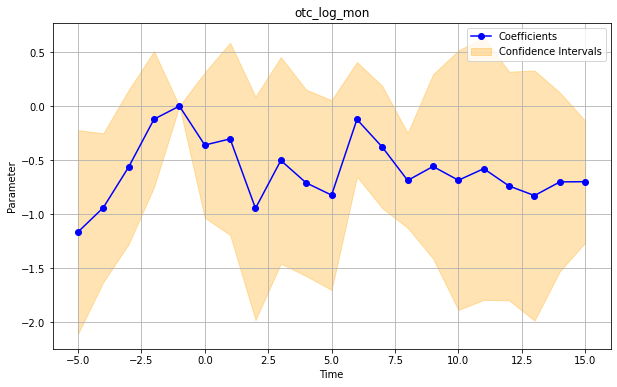

In [11]:
# take log

# till 20
# formula="log_otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+elasped_16+elasped_17+elasped_18+elasped_19+elasped_20+generic_per+TimeEffects+EntityEffects"

# till 15
formula="log_otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15"

# gemeric_per
formula+=" + generic_per"

# fixed effects
formula+=" + EntityEffects + TimeEffects"

# add lagged stock
# formula+="+log_stock_otc_lag"

# with month dummies
# formula+=months

# ytrend
# formula+=ytrend

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon",title="otc_log_mon")